Library installation

In [21]:
%%bash

sudo apt install curl

In [ ]:
!pip install dipy

Library import

In [1]:
import matplotlib.pylab as plt
import os
import numpy as np
from scipy.ndimage import binary_dilation

In [2]:
import nibabel as nib
from dipy.tracking import utils
from dipy.core.gradients import gradient_table
from dipy.io.gradients import read_bvals_bvecs
from dipy.io.image import load_nifti
from dipy.direction import peaks
from dipy.reconst import shm
from dipy.segment.mask import median_otsu
from dipy.tracking import utils
from dipy.tracking.local_tracking import LocalTracking
from dipy.tracking.stopping_criterion import BinaryStoppingCriterion
from dipy.tracking.streamline import Streamlines
from dipy.direction import peaks

/home/mzelasko/miniconda3/envs/ML4Neuro/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from dipy.io.stateful_tractogram import Space, StatefulTractogram
from dipy.io.streamline import save_trk

In [5]:
def take_import_text(number = 10159, short=False):
    # choose lines containing given number of directory
    f = open("./Data/ds000030-1.0.0.sh", "r")
    lines_array = f.readlines()
    lines_import_text = ""
    nii_gz_filenames = []
    for line in lines_array:
        if f"sub-{number}" in line[-60:] and (not short or "dwi" in line): 
            lines_import_text += line
            if "nii.gz" in line[-10:]:
                words = line.split(" ")
                nii_gz_filenames.append(words[-1][:-1])
    return lines_import_text, nii_gz_filenames

In [7]:
def create_bash_script(number = 10159, do_import = True, short = False, simple = True):
    # removing previous script
    try:
        os.system('rm ./Data/import_process_script.sh')
    except:
        print("No script file to remove!")

    # cut part of import script to download one directory
    bin_bash = f"#!/bin/bash\n"
    import_data, nii_gz_filenames = take_import_text(number, short)
    if not do_import: import_data = ""
    
    # extracting mask file from nii.gz files
    convert_data_fsl = "export FSLOUTPUTTYPE=NIFTI_GZ\nexport PATH=\"/usr/local/fsl/bin$PATH\"\nexport FSLDIR=\"/usr/local/fsl\"\n"
    for filename in nii_gz_filenames:
        if not simple: 
            convert_data_fsl += f"eddy_correct ./{filename} ./{filename[:-7]}_eddycorrected{filename[-7:]} -interp trilinear\n"
            convert_data_fsl += f"fslmaths ./{filename[:-7]}_eddycorrected{filename[-7:]} ./{filename[:-7]}_bet{filename[-7:]}\n"
        else:
            convert_data_fsl += f"fslmaths ./{filename} ./{filename[:-7]}_bet{filename[-7:]}\n"
        convert_data_fsl += f"flirt -ref ./{filename[:-7]}_bet{filename[-7:]} -in  ./atlas/MNI152lin_T1_1mm_brain.nii.gz -omat ./atlas/my_mat.mat\n"
        convert_data_fsl += f"flirt -ref ./{filename[:-7]}_bet{filename[-7:]} -in  ./atlas/aal.nii -applyxfm -init ./atlas/my_mat.mat -out ./atlas/atlas_reg.nii.gz -interp nearestneighbour\n"
    
    # create script and write it to file
    script_text = bin_bash + import_data + convert_data_fsl
    f = open("./Data/import_process_script.sh", "w")
    f.write(script_text)

In [14]:
# test of function creating singlw directory downloading script
# create_bash_script(short = True)

In [8]:
def run_script(number = 10159, do_import = True, short=False):
    # create script importing and converting single directory
    create_bash_script(number=number, do_import=do_import, short=short)

    # run script in bash
    os.system('bash ./Data/import_process_script.sh')

In [19]:
# test of running script for downloading files
# and creating brain masks necessary for further analyse
# run_script(short = True)

In [20]:
def process_to_streamlines(filename = None, number = 10159, do_draw = False):
    # load data
    if filename == None:
        data, affine, load_img = load_nifti(f"./sub-{number}/dwi/sub-{number}_dwi.nii.gz", return_img=True)
        bvals, bvecs = read_bvals_bvecs(f"./sub-{number}/dwi/sub-{number}_dwi.bval", f"./sub-{number}/dwi/sub-{number}_dwi.bvec")
        gtab = gradient_table(bvals, bvecs)
    else:
        data, affine, load_img = load_nifti(filename, return_img=True)
        bvals, bvecs = read_bvals_bvecs(f"./sub-{number}/dwi/sub-{number}_dwi.bval", f"./sub-{number}/dwi/sub-{number}_dwi.bvec")
        gtab = gradient_table(bvals, bvecs)

    atlas = nib.load('./atlas/atlas_reg.nii.gz')
    labels = atlas.get_fdata()
    labels = labels.astype(int)

    binary_dil = binary_dilation((labels < 10) | (labels >= 10)) 
    csamodel = shm.CsaOdfModel(gtab, 6)
    csapeaks = peaks.peaks_from_model(model=csamodel,
                                    data=data,
                                    # mask=mask,
                                    sphere=peaks.default_sphere,
                                    relative_peak_threshold=.8,
                                    min_separation_angle=45)

    affine = np.eye(4)
    seeds = utils.seeds_from_mask(binary_dil, affine, density=1)
    stopping_criterion = BinaryStoppingCriterion(binary_dil)

    # choosing tracks model
    streamline_generator = LocalTracking(csapeaks, stopping_criterion, seeds,
                                        affine=affine, step_size=0.5) # we can change stopping criterion here
    streamlines = Streamlines(streamline_generator)

    # choosing proper brain slice (verify if it is necessary)
    cc_slice = labels == 2
    cc_streamlines = utils.target(streamlines, affine, cc_slice)
    cc_streamlines = Streamlines(cc_streamlines)

    # save streamlines
    sft = StatefulTractogram(cc_streamlines, load_img, Space.VOX)
    save_trk(sft, "cc_streamlines.trk")

    # create connectivity matrix
    # print(cc_streamlines)
    M, _ = utils.connectivity_matrix(cc_streamlines, affine,
                                        labels.astype(np.uint8),
                                        return_mapping=True,
                                        mapping_as_streamlines=True)
    M[:3, :] = 0
    M[:, :3] = 0

    # plot cennectivity matrix
    if do_draw:
        plt.imshow(np.log1p(M), interpolation='nearest')
        plt.savefig(f"connectivity-{number}.png")
    # except:
    #     print(f"File = {filename}, number = {number}: Error while processing data")
    #     M = None

    return M

In [11]:
# test of processing to streamline
# print(process_to_streamlines(number = 10159, do_draw = True))
#AAL nifti atlas

In [21]:
def write_conectivity_matrix_to_file(M, number = 10159):
    # save connectivity matrix as a .txt file
    # filename consists a directory number
    f = open(f"./cc_matrices/connectivity-matrix-{number}.txt", "w")
    for row in M:
        for cell in row:
            f.write(str(cell) + ",")
        f.write("\n")

In [22]:
def remove_sub_directory(number):
    # remove downloaded directory with data
    try:
        os.system(f"rm -r sub-{number}")
    except:
        print("No directory to remove!")

In [23]:
def preprocess_single_record(number = 10159, do_draw = False, short = False, simple = False):
    # main function for data preprocessing
    run_script(number, short=short, simple = simple)
    M = process_to_streamlines(number = number, do_draw = do_draw)
    remove_sub_directory(number)
    if M is None:
        return False
    else:
        write_conectivity_matrix_to_file(M, number=number)
        return True

In [27]:
# test of processing single directory
# preprocess_single_record(number = 10159, do_draw = True, short = True)

In [24]:
def choose_directory_numbers(index = 0):
    index = index % 4
    f = open("./Data/ds000030-1.0.0.sh", "r")
    lines_array = f.readlines()
    directory_numbers_set = set()
    for line in lines_array:
        if f"_dwi.nii.gz" in line[-60:]: 
            directory_numbers_set.add(int(line[-17:-12]))
    directory_numbers_list = list(directory_numbers_set)
    directory_numbers_list = sorted(directory_numbers_list)
    n = len(directory_numbers_list)
    return directory_numbers_list[index * n // 4:(index + 1) * n // 4]

In [25]:
print(choose_directory_numbers(0), len(choose_directory_numbers(0)))
print(choose_directory_numbers(1), len(choose_directory_numbers(1)))
print(choose_directory_numbers(2), len(choose_directory_numbers(2)))
print(choose_directory_numbers(3), len(choose_directory_numbers(3)))

[10159, 10171, 10189, 10193, 10206, 10217, 10225, 10227, 10228, 10235, 10249, 10269, 10271, 10273, 10274, 10280, 10290, 10292, 10304, 10316, 10321, 10325, 10329, 10339, 10340, 10345, 10347, 10356, 10361, 10365, 10376, 10377, 10388, 10429, 10438, 10440, 10448, 10455, 10460, 10471, 10478, 10487, 10492, 10506, 10517, 10523, 10524, 10525, 10527, 10530, 10557, 10565, 10570, 10575, 10624, 10629, 10631, 10638, 10674, 10678, 10680, 10686, 10692, 10696, 10697] 65
[10704, 10707, 10708, 10719, 10724, 10746, 10762, 10779, 10785, 10788, 10844, 10855, 10871, 10877, 10882, 10891, 10893, 10912, 10934, 10940, 10948, 10949, 10958, 10963, 10968, 10975, 10977, 10987, 10998, 11019, 11030, 11044, 11050, 11052, 11059, 11061, 11062, 11066, 11067, 11068, 11077, 11082, 11088, 11090, 11097, 11098, 11104, 11105, 11106, 11108, 11112, 11122, 11128, 11131, 11142, 11143, 11149, 11156, 50004, 50005, 50006, 50007, 50008, 50010, 50013, 50014] 66
[50015, 50016, 50020, 50021, 50022, 50023, 50025, 50027, 50029, 50032, 5003

In [26]:
def print_process_dict(process_dict):
    print("Dir. num.: | Processed? ")
    for key, value in process_dict.items():
        print(f"{str(key).ljust(11)}| {str(value).ljust(10)}")

In [27]:
def proprocess_record_batch(index = 0, short = False, do_draw = False, simple = False):
    # download, create brain masks, process data
    # from given list of directories (represeted with numbers)
    # argument index id personal id for every team member 
    # running this code in order to preprocess a batch of data
    index_list = choose_directory_numbers(index)
    process_dict = {}
    index_list = [10159] # , 50004, 60001, 70001
    for number in index_list:
        print(f"Directory: sub-{number}")
        process_dict[number] = preprocess_single_record(number = number, do_draw = do_draw, short = short, simple = simple)
    print_process_dict(process_dict)

Directory: sub-10159


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   322  100   322    0     0    274      0  0:00:01  0:00:01 --:--:--   275
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1814  100  1814    0     0   1384      0  0:00:01  0:00:01 --:--:--  1385
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2007  100  2007    0     0   1897      0  0:00:01  0:00:01 --:--:--  1898
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 30.5M  100 30.5M    0     0   702k      0  0:00:44  0:00:44 --:--:-- 1053k


Dir. num.: | Processed? 
10159      | True      


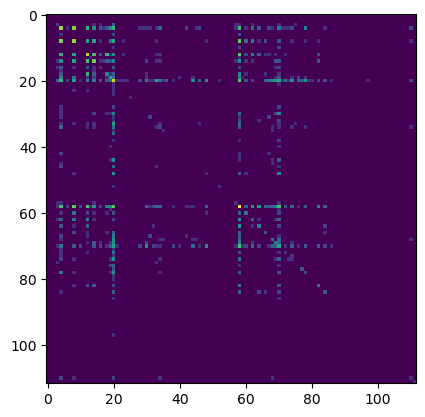

In [28]:
# put your index
proprocess_record_batch(index = 0, short = True, do_draw = True, simple = False) 